In [14]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from get_clean_data_FTbreakdown import get_data, clean_data

In [3]:
with open('form5500_data/config.json') as f:
    conf = json.load(f)
    host = conf['host']
    database = conf['database']
    user = conf['user']
    passw = conf['passw']
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)
conn = psycopg2.connect(conn_str)

In [4]:
query = '''SELECT sb.SB_EIN, sb.SB_PN, sb.SB_EFF_INT_RATE_PRCNT, sb.SB_PLAN_TYPE_CODE,
       sb.SB_TOT_PARTCP_CNT, sb.SB_ACT_PARTCP_CNT, SB_TERM_PARTCP_CNT, SB_RTD_PARTCP_CNT,
       sb.SB_TOT_FNDNG_TGT_AMT, SB_LIAB_ACT_TOT_FNDNG_TGT_AMT, SB_TERM_FNDNG_TGT_AMT, SB_RTD_FNDNG_TGT_AMT,
       f.PLAN_NAME, f.SPONSOR_DFE_NAME
       FROM sb_full sb 
       LEFT JOIN f5500_full f 
       ON sb.SB_EIN = f.SPONS_DFE_EIN AND sb.SB_PN = f.SPONS_DFE_PN 
       WHERE sb.SB_PLAN_YEAR_BEGIN_DATE BETWEEN '2017-01-01' AND '2017-12-31';'''

In [5]:
df = pd.read_sql(query, con=conn)
conn.close()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24273 entries, 0 to 24272
Data columns (total 14 columns):
sb_ein                           24273 non-null int64
sb_pn                            24273 non-null int64
sb_eff_int_rate_prcnt            24238 non-null float64
sb_plan_type_code                24273 non-null object
sb_tot_partcp_cnt                24244 non-null float64
sb_act_partcp_cnt                24216 non-null float64
sb_term_partcp_cnt               23972 non-null float64
sb_rtd_partcp_cnt                23858 non-null float64
sb_tot_fndng_tgt_amt             24250 non-null float64
sb_liab_act_tot_fndng_tgt_amt    24204 non-null float64
sb_term_fndng_tgt_amt            23949 non-null float64
sb_rtd_fndng_tgt_amt             23840 non-null float64
plan_name                        9234 non-null object
sponsor_dfe_name                 9234 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 2.6+ MB


<h3>Convert object counts to numeric</h3>

In [12]:
clean_list = ['sb_tot_partcp_cnt', 'sb_act_partcp_cnt','sb_term_partcp_cnt', 'sb_rtd_partcp_cnt']

for c in clean_list:
    df[c] = pd.to_numeric(df[c])

df['sb_eff_int_rate_prcnt'] = np.where(df['sb_eff_int_rate_prcnt']>100, df['sb_eff_int_rate_prcnt']/100, df['sb_eff_int_rate_prcnt'])

<h3>Remove outliers and plans with $0 FT</h3>

In [58]:
df=df[(df['sb_tot_partcp_cnt']< 4000000) & (df['sb_tot_fndng_tgt_amt']>0) & \
       (df['sb_act_partcp_cnt']< 300000) & (df['sb_term_partcp_cnt'] < 100000) & \
        (df['sb_rtd_partcp_cnt']< 100000)]

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sb_ein,22306.0,4.433125e+08,2.745883e+08,10020240.00,2.223861e+08,3.645830e+08,6.504331e+08,9.903542e+08
sb_pn,22306.0,3.285484e+00,1.716091e+01,1.00,1.000000e+00,2.000000e+00,2.000000e+00,3.980000e+02
sb_eff_int_rate_prcnt,22297.0,5.673017e+00,5.241598e-01,0.08,5.630000e+00,5.760000e+00,5.930000e+00,1.140000e+01
sb_tot_partcp_cnt,22306.0,5.208105e+02,5.930157e+03,0.00,4.000000e+00,8.000000e+00,2.600000e+01,1.793500e+05
sb_act_partcp_cnt,22306.0,1.529286e+02,1.727289e+03,0.00,3.000000e+00,6.000000e+00,1.700000e+01,8.941000e+04
sb_term_partcp_cnt,22306.0,1.523051e+02,2.001048e+03,0.00,0.000000e+00,1.000000e+00,5.000000e+00,9.312700e+04
sb_rtd_partcp_cnt,22306.0,2.155768e+02,2.709486e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,8.966500e+04
sb_tot_fndng_tgt_amt,22306.0,4.583094e+07,6.860207e+08,1.00,4.061755e+05,9.889200e+05,2.500270e+06,2.995327e+10
sb_liab_act_tot_fndng_tgt_amt,22306.0,1.623374e+07,2.625266e+08,0.00,3.385830e+05,8.489690e+05,1.969188e+06,1.111749e+10
sb_term_fndng_tgt_amt,22294.0,6.377512e+06,8.911647e+07,0.00,0.000000e+00,6.125000e+02,6.849900e+04,3.705227e+09


<h1>Funding Target vs Participant Count - Total and by Status</h1>

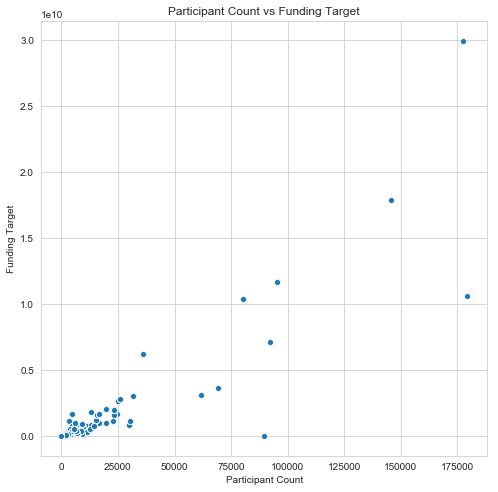

In [60]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_tot_partcp_cnt'], y=df['sb_tot_fndng_tgt_amt'])
plt.title('Participant Count vs Funding Target')
plt.xlabel('Participant Count')
plt.ylabel('Funding Target')
plt.show()

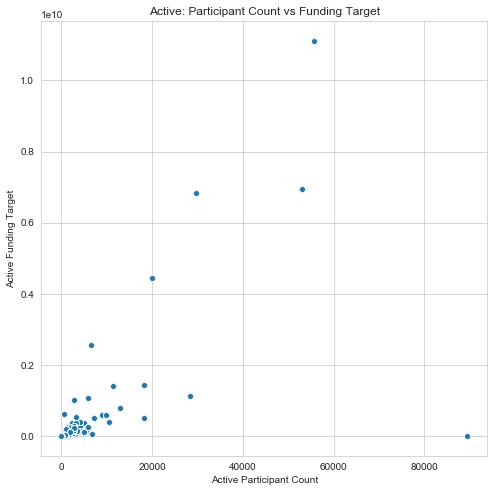

In [61]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_act_partcp_cnt'], y=df['sb_liab_act_tot_fndng_tgt_amt'])
plt.title('Active: Participant Count vs Funding Target')
plt.xlabel('Active Participant Count')
plt.ylabel('Active Funding Target')
plt.show()

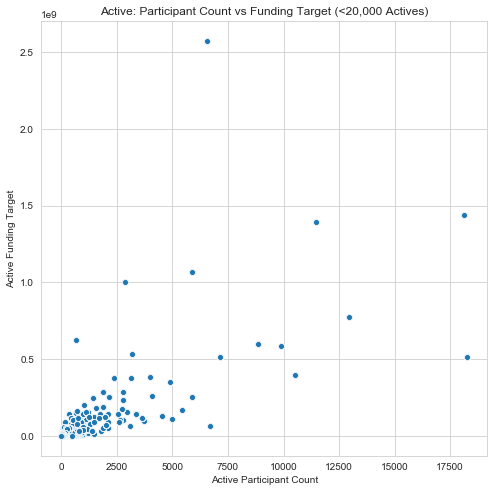

In [62]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
x=df[df['sb_act_partcp_cnt']<20000]['sb_act_partcp_cnt']
y=df[df['sb_act_partcp_cnt']<20000]['sb_liab_act_tot_fndng_tgt_amt']
ax = sns.scatterplot(x=x, y=y)
plt.title('Active: Participant Count vs Funding Target (<20,000 Actives)')
plt.xlabel('Active Participant Count')
plt.ylabel('Active Funding Target')
plt.show()

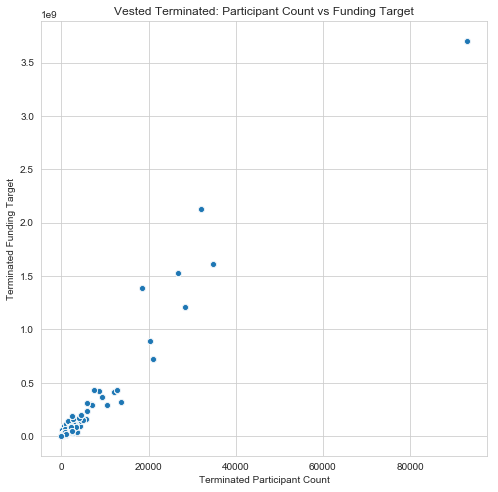

In [63]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_term_partcp_cnt'], y=df['sb_term_fndng_tgt_amt'])
plt.title('Vested Terminated: Participant Count vs Funding Target')
plt.xlabel('Terminated Participant Count')
plt.ylabel('Terminated Funding Target')
plt.show()

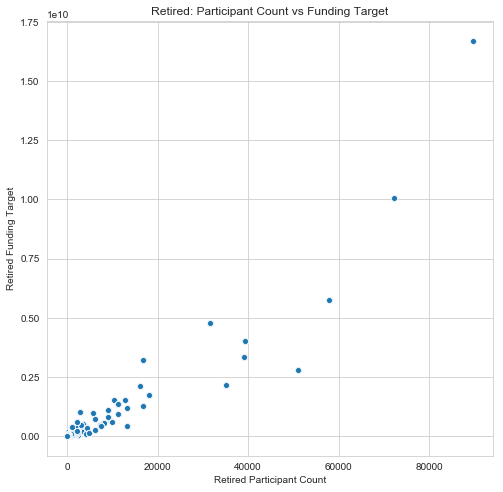

In [64]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_rtd_partcp_cnt'], y=df['sb_rtd_fndng_tgt_amt'])
plt.title('Retired: Participant Count vs Funding Target')
plt.xlabel('Retired Participant Count')
plt.ylabel('Retired Funding Target')
plt.show()

In [65]:
df.columns

Index(['sb_ein', 'sb_pn', 'sb_eff_int_rate_prcnt', 'sb_plan_type_code',
       'sb_tot_partcp_cnt', 'sb_act_partcp_cnt', 'sb_term_partcp_cnt',
       'sb_rtd_partcp_cnt', 'sb_tot_fndng_tgt_amt',
       'sb_liab_act_tot_fndng_tgt_amt', 'sb_term_fndng_tgt_amt',
       'sb_rtd_fndng_tgt_amt', 'plan_name', 'sponsor_dfe_name'],
      dtype='object')

<h3>Distribution of Participant Count</h3>

In [ ]:
sns.distplot(X2[(X2['sb_tot_partcp_cnt']<4000) & (X2['sb_tot_partcp_cnt']>100)]['sb_tot_partcp_cnt'],\
            bins=100)
plt.title('Distribution of Participant Count (100 < PC < 4000)')
plt.show()

In [ ]:
sns.distplot(X2[(X2['sb_tot_partcp_cnt']<1000) & (X2['sb_tot_partcp_cnt']>100)]['sb_tot_partcp_cnt'],\
            bins=100)
plt.title('Distribution of Participant Count (100 < PC < 1000)')
plt.show()

<h2>Participant Count vs. Funded Status</h2>

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=X2['sb_tot_partcp_cnt'], y=y)
plt.title('Participant Count vs Funded Status')
plt.show()

In [ ]:
fig1, ax1 = plt.subplots(1,1, figsize=(8,8))
x_trnc=X2[X2['sb_tot_partcp_cnt']<50000]['sb_tot_partcp_cnt']
y_trnc=np.clip(y[X2['sb_tot_partcp_cnt']<50000],0,400)
ax1 = sns.scatterplot(x=x_trnc, y=y_trnc)
plt.title('Participant Count vs Funded Status - ptp cnt < 50000, clip FS > 400%')
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(1,1, figsize=(8,8))
x_trnc2=X2[X2['sb_tot_partcp_cnt']<10000]['sb_tot_partcp_cnt']
y_trnc2=np.clip(y[X2['sb_tot_partcp_cnt']<10000],0,400)
ax2 = sns.scatterplot(x=x_trnc2, y=y_trnc2)
plt.title('Participant Count vs Funded Status - ptp cnt < 10000, clip FS > 400%')
plt.show()

<h2>EIR vs Funded Status</h2>

In [ ]:
fig3, ax3 = plt.subplots(1,1, figsize=(8,8))
#x_trnc3=X2[(X2['sb_eff_int_rate_prcnt'] >1) & (X2['sb_eff_int_rate_prcnt'] < 10)]['sb_eff_int_rate_prcnt']
#y_trnc3=np.clip(y[(X2['sb_eff_int_rate_prcnt'] >1) & (X2['sb_eff_int_rate_prcnt'] < 10)],0,400)
x_trnc3=X2['sb_eff_int_rate_prcnt']
y_trnc3=np.clip(y,0,400)
ax3 = sns.scatterplot(x=x_trnc3, y=y_trnc3)
plt.title('EIR vs Funded Status: 1% < EIR < 10%, clip FS > 400%')
plt.show()

In [ ]:
fig4, ax4 = plt.subplots(1,1, figsize=(8,8))
x_trnc4=X2[(X2['sb_eff_int_rate_prcnt'] >4) & (X2['sb_eff_int_rate_prcnt'] < 6.5)]['sb_eff_int_rate_prcnt']
y_trnc4=np.clip(y[(X2['sb_eff_int_rate_prcnt'] >4) & (X2['sb_eff_int_rate_prcnt'] < 6.5)],0,400)
ax4 = sns.scatterplot(x=x_trnc4, y=y_trnc4)
plt.title('EIR vs Funded Status: 4% < EIR < 6.5%, clip FS > 400%')
plt.show()

<h2>PY FS vs CY FS</h2>

In [ ]:
fig5, ax5 = plt.subplots(1,1, figsize=(8,8))
x_trnc5=X2['sb_pr_yr_fndng_prcnt']
y_trnc5=np.clip(y,0,400)
ax5 = sns.scatterplot(x=x_trnc5, y=y_trnc5)
plt.xlim(0,400)
plt.title('PY Funded Status vs Funded Status')
plt.rcParams.update({'font.size':12})
plt.show()

In [ ]:
sns.boxplot(x=X2[X2['sb_tot_partcp_cnt']<10000]['sb_tot_partcp_cnt'])
plt.show()

In [ ]:
sns.boxplot(x=X2['sb_eff_int_rate_prcnt'])
plt.show()

In [ ]:
sns.boxplot(x=X2['sb_pr_yr_fndng_prcnt'])
plt.show()

In [ ]:
X2.head()